<a href="https://colab.research.google.com/github/ThomasMiconi/HebbianCNNPyTorch/blob/main/HebbGrad_Github.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This code implements Hebbian learning in convolutional networks in PyTorch, simply by specifying a loss whose gradient turn out to produce exactly the desired Hebbian updates, for any of several Hebbian rules (plain Hebbian, Instar, Oja's).

It is highly recommended that you check the "simple" version first (in the same repository).

This is the actual code used to obtain the results described in the preprint.

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import pdb
import matplotlib.pyplot as plt

import scipy
from scipy import ndimage
from scipy import linalg

import torchvision
import torchvision.transforms as transforms

import os
import argparse
import time

import numpy as np
from numpy import fft 

from scipy import io as spio



# NL = number of layers, N = number of output channels per layer, K = number of winners in the WTA for each column

#NL=4; STRIDES=(3,2,2,2); POOLSTRIDES = (1, 1, 1, 1); POOLDIAMS = (1, 1, 1, 1) ; SIZES = (6, 3, 3, 3) ; NBOUT = 9; N = [64, 100, 196, 400]; K = [1,2,4,8]; DILATIONS=None
#NL=4; STRIDES=(1,1,1,1); POOLSTRIDES = (2, 2, 2, 2); POOLDIAMS = (2, 2, 2, 2) ; SIZES = (6, 3, 3, 3) ; NBOUT = 9; N = [64, 128, 196, 400]; K = [1,2,4,8]; DILATIONS=None
#NL=2; STRIDES=(10,2,2,2); POOLSTRIDES = (1, 1, 1, 1); POOLDIAMS = (1, 1, 1, 1) ; SIZES = (10, 3, 3, 3) ; NBOUT = 1; N = [400, 100, 100, 100]; K = [1,2,4,8]; DILATIONS=None
#NL=3; STRIDES=(1,1,1,1); POOLSTRIDES = (2, 2, 2, 2); POOLDIAMS = (2, 2, 2, 2) ; SIZES = (5, 3, 3, 3) ; NBOUT = 4; N = [100, 196, 400, 400]; K = [1, 1, 1, None]; DILATIONS=None
#NL=3; STRIDES=(1,1,1,1); POOLSTRIDES = (2, 2, 2, 2); POOLDIAMS = (2, 2, 2, 2) ; SIZES = (5, 3, 3, 3) ; NBOUT = 4; N = [100, 196, 400, 100]; K = [1, 2, 4, None]; DILATIONS=None
NL=3; STRIDES=(1,1,1); POOLSTRIDES = (2, 2, 2); POOLDIAMS = (2, 2, 2) ; SIZES = (5, 3, 3) ; N = [100, 196, 400, 100]; K = [1, 1, 1]

# Should we use pruning / masking of weights? Probability for each layer.
#PROBAMASK =  .75 # .97 
#PROBAMASKS = (0, 0.5, 0.5, 0.5)
#PROBAMASKS = (0, 0.9, 0.9, 0.9)
#PROBAMASKS = (0, 0.95, 0.95, 0.95)
#PROBAMASKS = (0, 0.98, 0.98, 0.98)
#PROBAMASKS = (0, 0.999, 0.999, 0.999)
# PROBAMASKS = (0, 0., 0., 0.)
PROBAMASKS = (0, 0.99, 0.99)

# Do we apply the ZCA to the whole image (IMAGE), individually to each patch through the unfolding/flattening convolution ("method 2" in the preprint) (FLAT), as a spatial filter (highly experimental, FILTER), or not at all? 
ZCA = 'IMAGE' # FLAT, IMAGE, FILTER, None 

BINARIZEDPLAST = True   # Binarized WTA for plasticity?
LEARNONLYL1 = False     # Learning only in Layer 1 (for tests)?
USEFLAT = False         # Use the flattening/unfolding convolution ("method 2" in the preprint)?
NORMW = True            # Constrain weights to norm 1?
USETHRES = True         # Use adaptive thresholds?

# Use Coates' "triangle" method? If TRAINTEST: Don't use it during Hebbian learning, but do use it during data collection for training/testing the linear classifier.
USETRIANGLE = 'YES' # 'NO', 'YES', 'TRAINTEST'
L1PEN =  [0, 0, 0] # ; L1PEN = [-0.0 * xx for xx in L1PEN] ; print(L1PEN[2])

#TARGETRATE = [1.0/36, 2.0/400, 0.01, 0.01] 
#TARGETRATE = [0.05, 0.003, 0.01, 0.01] 
#TARGETRATE = [2/N[0], 2/N[1], 5/N[2]] # [3/xx for xx in N] 
TARGETRATE = [float(K[ii] / N[ii]) for ii in range(NL)]     # When using adaptive threshold, the target "firing" (k-WTA winning) rate must be K/N, otherwise trouble happens.

BATCHSIZE=100

RGB = True  # RGB or Grayscale?
NBINPUTCHANNELS = 3 if RGB else 1


CSIZE =    32       #  Size of input images
FSIZE = 32          # Size of whitening filter. Should be CSIZE for ZCA=IMAGE, SIZES[0] for ZCA=FLAT.
MIXDOG = 1.0        # For the Difference of Gaussians filter below. No longer used
NBLEARNINGEPOCHS = 20   # Number of learning epochs. Add 2 epochs with frozen weights for collecting training/testing data for the linear classifier.
LR = [ 0.001 / BATCHSIZE,  0.001 / BATCHSIZE,  10 * .001 / BATCHSIZE]   # Learning rates for each layer. We learn faster in the last layer, which has little data (only 2x2 outputs, only 1 winner for 400 filters each time)
LR = [xx * 10.0 for xx in LR]
MUTHRES =  3.0      #  Adaptation rate for adaptive thresholds


# This computation of receptive field sizes may not be correct anymore.
rfL1size = SIZES[0]  # Assumes no dilation in L1 
rfL2size = STRIDES[0] * POOLSTRIDES[0]*(SIZES[1]-1)+SIZES[0]
rfL3size = STRIDES[1] * POOLSTRIDES[1]*STRIDES[0] * POOLSTRIDES[0]* (SIZES[2]-1)+rfL2size
print("RF sizes: L1:", rfL1size, "L2:", rfL2size, "L3:", rfL3size )


tic = time.time()

device = 'cuda' if torch.cuda.is_available() else 'cpu'



# PyTorch data loading boilerplate. Note the multiple conditions. "UNLAB" = unlabelled (Hebbian learning)

if RGB:    
    transform_zca = transforms.Compose([
        torchvision.transforms.RandomHorizontalFlip(),
    #torchvision.transforms.RandomRotation(45),
            transforms.RandomCrop(FSIZE),  
        transforms.ToTensor(),
    ])
    transform_unlab = transforms.Compose([
        torchvision.transforms.RandomHorizontalFlip(),
    #torchvision.transforms.RandomRotation(45),
            transforms.RandomCrop(CSIZE),  # Larger image
        transforms.ToTensor(),
    ])
    transform_train = transforms.Compose([
        torchvision.transforms.RandomHorizontalFlip(),
            transforms.RandomCrop(CSIZE),  # Larger image
        transforms.ToTensor(),
    ])
else:
    transform_zca = transforms.Compose([
    torchvision.transforms.Grayscale(),
    torchvision.transforms.RandomHorizontalFlip(),
    #torchvision.transforms.RandomRotation(45),
    transforms.RandomCrop(FSIZE),  # Larger image
    transforms.ToTensor(),
    ])
    transform_unlab = transforms.Compose([
    torchvision.transforms.Grayscale(),
    torchvision.transforms.RandomHorizontalFlip(),
    #torchvision.transforms.RandomRotation(45),
    transforms.RandomCrop(CSIZE),  # Larger image
    transforms.ToTensor(),
    ])
    transform_train = transforms.Compose([
    torchvision.transforms.Grayscale(),
    torchvision.transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(CSIZE),  # Larger image
    transforms.ToTensor(),
    ])
transform_test = transform_train
# trainset = torchvision.datasets.CIFAR10(
#    root='./data', train=True, download=True, transform=transform_train)
# trainloader = torch.utils.data.DataLoader(
#    trainset, batch_size=BATCHSIZE, shuffle=False)#, num_workers=2) # Also check out pin_memory if using GPU


# STL10 data. Potentially useful for unsupervised learning !  Requires adjusting the size parameters.
# unlabloader = trainloader = testloader = None
# trainset = torchvision.datasets.STL10(
#    root='./data', split='train', download=True, transform=transform_train)
# testset = torchvision.datasets.STL10(
#     root='./data', split='test', download=True, transform=transform_test)
# unlabset = torchvision.datasets.STL10(
#     root='./data', split='unlabeled', download=True, transform=transform_unlab)
# zcaset = torchvision.datasets.STL10(
#     root='./data', split='unlabeled', download=True, transform=transform_zca)

trainset = torchvision.datasets.CIFAR10(
   root='./data', train=True, download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)
unlabset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_unlab)
zcaset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_zca)


zcaloader = torch.utils.data.DataLoader(
    zcaset, batch_size=9000, shuffle=True, num_workers=2)
trainloader = torch.utils.data.DataLoader(
   trainset, batch_size=BATCHSIZE, shuffle=True, num_workers=2) # Also check out pin_memory if using GPU
testloader = torch.utils.data.DataLoader(
    testset, batch_size=BATCHSIZE, shuffle=False, num_workers=2)
unlabloader = torch.utils.data.DataLoader(
    unlabset, batch_size=BATCHSIZE, shuffle=True, num_workers=2)


# The Olshausen & Field images. Must be downloaded from Bruno Olshausen's website.
#OP = spio.loadmat('IMAGES.mat')['IMAGES'] # Olshausen pictures, 512 * 512 * 10
#OP = spio.loadmat('IMAGES_RAW.mat')['IMAGESr'].astype(np.float32) # Olshausen pictures, 512 * 512 * 10
#OP = OP - np.min(OP); OP = OP / np.max(OP)




# Initializations. Some of that stuff is not used anymore.

# w has shape OutChannels, InChannels, H, W
w=[]; masks = []
wflat=[]
wlat=[]; wlatdecay=[]
meanfiringrates=[];meanfiringrates_p=[]; meanrealy=[]; meanabsprelimy=[]
allthres=[]; allfirings = []; allfirings_p = []
meancorry = [] ; meancorrp = []
optimizers=[]
DeccFilts = []
thres=[]; C = []
for numl in range(NL):

    # For the flattening convolution, wflat are the fixed weights:
    if numl == 0:
        NIC = NBINPUTCHANNELS
    else:
        NIC = N[numl-1]
    idx = 0
    wf =  torch.zeros((NIC * SIZES[numl] * SIZES[numl], NIC, SIZES[numl], SIZES[numl]), requires_grad=False, device=device) 
    for nin in range(NIC):
        for xin in range(SIZES[numl]):
            for yin in range(SIZES[numl]):
                wf.data[idx, nin, xin, yin] = 1
                idx += 1
    wflat.append(wf)

    # The actual (learned) weights:
    if  USEFLAT:
        # when using the flattening / unfolding convolution :
        wi = torch.randn((N[numl], NIC * SIZES[numl] * SIZES[numl], 1, 1), requires_grad=True, device=device) 
    else:
        # When *not* using the flattening convolution
        wi = torch.randn((N[numl], NIC, SIZES[numl], SIZES[numl]), requires_grad=True, device=device) 

    wi.data = wi.data * .01
    
    if True: # PROBAMASK > 0:
        mi = (torch.rand_like(wi, requires_grad=False) > PROBAMASKS[numl]).float().to(device)
        if numl == 0:
            mi.fill_(1.0)
        masks.append(mi)
        wi.data = wi.data * mi.data
    w.append(wi)
    if NORMW:
        # w has shape OutChannels, InChannels, H, W
        w[numl].data =    w[numl].data  / (1e-10 + torch.sqrt(torch.sum(w[numl].data ** 2, dim=[1,2,3], keepdim=True)))
    wlat.append( torch.zeros((N[numl], N[numl]), requires_grad=False, device=device) ) 
    wlatdecay.append( torch.zeros((N[numl], N[numl]), requires_grad=False, device=device) ) 

    C.append(0)
    meancorry.append(torch.zeros((N[numl], N[numl]), requires_grad=False, device=device))
    meancorrp.append(torch.zeros((N[numl], N[numl]), requires_grad=False, device=device))
    allthres.append([])
    allfirings.append([])
    allfirings_p.append([])
    meanfiringrates.append(torch.zeros((1,N[numl],1,1), requires_grad=False).to(device))
    meanfiringrates_p.append(torch.zeros((1,N[numl],1,1), requires_grad=False).to(device))
    meanrealy.append(torch.zeros((1,N[numl],1,1), requires_grad=False).to(device))
    meanabsprelimy.append(torch.zeros((1,N[numl],1,1), requires_grad=False).to(device))
    thres.append(torch.zeros_like(meanfiringrates[numl], requires_grad=False).to(device))
    optimizers.append(optim.SGD((w[numl],), lr=LR[numl], momentum=0.0))
    #optimizers.append(optim.Adam((w[numl],), lr=3e-4))

realys = [0] * NL; prelimys = [0] * NL; xs = [0] * NL


assert ZCA in ['FILTER', 'IMAGE', 'FLAT', None]
assert USETRIANGLE in ['TRAINTEST', 'YES', 'NO']
if ZCA == 'FLAT':
    assert USEFLAT
    assert FSIZE == SIZES[0]
if ZCA == 'IMAGE':
    assert FSIZE == CSIZE
if ZCA == 'FILTER':
    # Not strictly necessary (unlike the previous 2), but works better that way. Try it with e.g. FSIZE=10 - greenish RFs!
    assert FSIZE == SIZES[0]


# We're building the ZCA matrix, and also (experimentally) a spatial filter based on that matrix.
if True:
    print("Building ZCA filter...")
    tuc = time.time()
    (xorig, targets) = next(iter(zcaloader))
    xorig = xorig.to(device)
    xshape = xorig.shape

    if ZCA == 'FLAT':
        # Applying the flattening convolution so each input patch of the weight convolution is a single vector
        # FSIZE should be = SIZES[0]
        # Output of "flattening" convolution then has shape (batchsize x nbinputchannels*fsize*fsize x 1 x 1), before squeeze.
        t = xorig.clone()
        t = F.conv2d(t, wflat[0]).squeeze().detach() 
    else:
        # Reshaping to vectorize whole images - when using whole-image ZCA matrix
        # FSize should be whole image size !
        t = xorig.clone().reshape([xshape[0], -1])
        #t = t - np.min(t, axis=2, keepdims=True; t = t / np.max(t, axis=2, keepdims=True)


    # Note the axis=1 (axis=0, i.e. batch norm, gives slightly worse performance)
    t = t - torch.mean(t, axis=1, keepdims=True)
    t = t / (1e-10 +  torch.std(t, axis=1, keepdims=True))

    
    covt = torch.matmul(t.T, t) / t.shape[1]  # Covariance matrix of the data vectors. Should have shape nbinputchannels*Fsize*Fsize ^ 2 
    covt += torch.diag(1e-3*torch.ones(covt.shape[0]).to(device))  # Regularization constant added to diagonal.


    #print(torch.min(t), torch.max(t), torch.median(t), "covt.shape:", covt.shape)
    (eivals, eivects) = torch.symeig(covt, eigenvectors=True)  # May get some negative eigenvalues due to noise, hence need for regularization constant above.
    assert torch.all((eivals)>0)
    eivalssqrt = 1.0 / torch.sqrt(eivals)
    #x˜ = E D^−1/2 Et x 
    zcamat = torch.matmul(torch.matmul(eivects, torch.diag(eivalssqrt)), eivects.T)

    
    # We now build a spatial filter that seeks to approximate the effect of the ZCA matrix. This would be very advantageous for large images.
    # This code is highly experimental. It kind of works if the filter size is small enough. It can probably be done much better.

    zcafilt = torch.zeros((NBINPUTCHANNELS, NBINPUTCHANNELS, xshape[2], xshape[3]), requires_grad=False).to(device)
    for nchan in range(NBINPUTCHANNELS):
        dirac = torch.zeros(NBINPUTCHANNELS, xshape[2], xshape[3]).to(device)
        dirac[nchan, xshape[2]//2, xshape[3] //2] = 1
        vdirac = torch.flatten(dirac)
        outs = torch.matmul(zcamat, vdirac)
        outs = outs.reshape(NBINPUTCHANNELS, xshape[2], xshape[3])
        zcafilt[:, nchan, :, :] = outs[:, :, :]

    
    zcafilt = zcafilt - torch.mean(zcafilt, axis=(2,3), keepdims=True)  # Highly empirical
    ###zcafilt = zcafilt - torch.mean(zcafilt, axis=(1,2,3), keepdims=True)  # Highly empirical
    #zcafilt = zcafilt - torch.mean(zcafilt, axis=(0,2,3), keepdims=True)  # Highly empirical
    #zcafilt = zcafilt - torch.mean(zcafilt)  # Highly empirical

    zcafilt = zcafilt.to(device)
    ZCAFilt = torch.nn.Conv2d(NBINPUTCHANNELS, NBINPUTCHANNELS, FSIZE, padding=(FSIZE//2), bias=False, padding_mode='reflect')
    ZCAFilt.weight = torch.nn.Parameter(zcafilt, requires_grad=False)
    #zcamat = zcamat.to(device)
    print("Done in", time.time()-tuc, "!")



# The original full-image-size Olshausen&Field filter, to be applied by multiplication in frequency domain. Not used in this code.
xr = np.arange(-CSIZE//2, CSIZE//2, 1)
yr = np.arange(-CSIZE//2, CSIZE//2, 1)
(fx, fy) = np.meshgrid(xr, yr)
rho = np.sqrt(fx*fx + fy*fy)
filt = rho * np.exp(- (rho / (0.4*CSIZE)) ** 4) # Reduce divider > lower-freq RFs 
freqfilt = torch.fft.fftshift(torch.Tensor(filt).to(device) )

# A modified version that is to be applied by convolution in the spatial domain. Note that frequency effects are different (because the pass-band is proportional to filter size).
xr = np.arange(-FSIZE//2, FSIZE//2, 1)
yr = np.arange(-FSIZE//2, FSIZE//2, 1)
(fx, fy) = np.meshgrid(xr, yr)
rho = np.sqrt(fx*fx + fy*fy)
filt = rho * np.exp(- (rho / (0.4*FSIZE)) ** 4) 
sfilt = fft.fftshift(np.real(fft.ifft2(fft.fftshift(filt))))   # Inverse FFT of the O&F filter - i.e. the O&F filter in the spatial domain



# Difference-of-Gaussian kernel. Not used. 
gk1 = np.zeros((FSIZE, FSIZE)); gk1[FSIZE//2, FSIZE//2] = 1
#gk2 = scipy.ndimage.gaussian_filter(gk1,sigma=.5) - scipy.ndimage.gaussian_filter(gk1,sigma=1.0) # Smaller sigmas lead to thinner / higher freq. RFs
gk2 = (1.0-MIXDOG) * gk1 + MIXDOG * (scipy.ndimage.gaussian_filter(gk1,sigma=.5) - scipy.ndimage.gaussian_filter(gk1,sigma=1.0)) # Smaller sigmas lead to thinner / higher freq. RFs
gk3 = np.repeat(gk2[np.newaxis,:,:], NBINPUTCHANNELS, axis=0)
gkOF = np.repeat(sfilt[np.newaxis,:,:], NBINPUTCHANNELS, axis=0)
dog = torch.Tensor(gk3[:,np.newaxis,:,:]).to(device) #  Adding a singleton dimension for inchannels/nbgroups=1
dogOF = torch.Tensor(gkOF[:,np.newaxis,:,:]).to(device) #  Adding a singleton dimension for inchannels/nbgroups=1

# Some kind of DoG filter with cross-inhibition across filters. Don't use.
# Conv2d filter weights have dimensions OutC, InC/groups, Ksize0, Ksize1 
gpos = scipy.ndimage.gaussian_filter(gk1,sigma=.5)
gneg = -scipy.ndimage.gaussian_filter(gk1,sigma=1.0)
gfilt = np.zeros((NBINPUTCHANNELS, NBINPUTCHANNELS, FSIZE, FSIZE))
for nchan in range(NBINPUTCHANNELS):
    gfilt[nchan, nchan, :, :] = gpos[:,:]
    for nchaninhib in range(NBINPUTCHANNELS):
        gfilt[nchan, nchaninhib, :, :] += gneg[:, :]  / NBINPUTCHANNELS
dogXI = torch.nn.Parameter(torch.tensor(gfilt.astype('float32'), requires_grad=False).to(device), requires_grad=False)
DoGCrossInhib = torch.nn.Conv2d(NBINPUTCHANNELS, NBINPUTCHANNELS, FSIZE, padding=FSIZE//2, bias=False, padding_mode='reflect')
DoGCrossInhib.weight = dogXI



print("Init time:", time.time()-tic, "Device:", device)
tic = time.time()
firstpass=True
nbbatches = -1
wsav = []

testaccs=[]; trainaccs=[]
trainouts = []; trainouts_lin= []; trainouts_nomp = []; trainoutsq_l1 = []; trainoutsq_l2=[]; trainoutsq_l3=[]; traintargets = []; 
testouts = []; testouts_lin=[]; testouts_nomp=[]; testoutsq_l1 = []; testoutsq_l2=[]; testoutsq_l3=[]; testtargets = [] 



# Start the experiment !

for epoch in range(NBLEARNINGEPOCHS + 2):

    print("Epoch", epoch)
    correct=0; total=0
    if epoch < NBLEARNINGEPOCHS:
        # Hebbian learning, unlabeled
        print("Unlabeled.")
        TESTING=False; TRAINING = False; UNLAB = True; 
        zeloader = unlabloader
    else: # epoch  < UNLABPERIOD + TRAINPERIOD:
        if epoch == NBLEARNINGEPOCHS:
            # With frozen weights, acquire network responses to training set
            TESTING=False; TRAINING = True; UNLAB = False; 
            zeloader = trainloader
            print("Training top layer only!")
        elif epoch == NBLEARNINGEPOCHS + 1:
            # With frozen weights, acquire network responses to training set 
            TESTING=True; TRAINING = False; UNLAB = False
            zeloader=testloader
            print("Testing...")
        else:
            raise(ValueError("Wrong epoch!")) 


    if (epoch % 3) == 0: 
           wsav.append([xx.data.cpu().numpy() for xx in w])


    for numbatch, (x, targets) in enumerate(zeloader):

        with torch.no_grad():

            
            nbbatches += 1

            # First, load and prepare the image data

            x = x.to(device)
            if TRAINING or TESTING:
                targets = targets.to(device)

            xorig = x.detach().clone()

            x = x - torch.mean(x, dim=(1, 2,3),keepdim=True);  x = x / (1e-10 + torch.std(x, dim=(1, 2,3), keepdim=True)) 

            # Convolving with the DoG kernel 
            if False:
                #x = F.conv2d(xorig, dogOF, groups=NBINPUTCHANNELS).detach()   # Not sure if detach helps.
                x = DoGCrossInhib(x).detach()
                #x = np.sqrt(0.1) * x / np.sqrt(float(torch.var(x)))
                x = x - torch.mean(x)
                x = x / np.sqrt(float(torch.var(x)))
            
            # Convolving with the ZCA kernel (highly experimental)
            if ZCA == 'FILTER':
                raise ValueError # We should normalize before? 
                x = ZCAFilt(x)
                #x = x - torch.mean(x)
                # x = 2.0 * x / np.sqrt(float(torch.var(x)))


            # Multiply whole images by full ZCA matrix, after whole-image normalization
            if ZCA == 'IMAGE':
                assert FSIZE == CSIZE
                xshape = x.shape
                t = x.reshape([xshape[0], -1])
                t = t - torch.mean(t, axis=1, keepdims=True)
                t = t / (1e-10 + torch.std(t, axis=1, keepdims=True))
                
                tzca = torch.matmul(zcamat, t.T).T
                x = tzca.reshape(xshape)
                # x=x.detach()
            
            xorig2 = x + 1e-10 # Just for debugging purposes



        # Now run the layers in succession
        for numl in range(NL):
            optimizers[numl].zero_grad()

            #Prepare the input to the layer
            with torch.no_grad():
                # Normalize each element in the batch
                x = x - torch.mean(x, dim=(1, 2,3),keepdim=True);  x = x / (1e-10 + torch.std(x, dim=(1, 2,3), keepdim=True)) 

                # If required, apply the "flattening"/unfolding convolution, separating each individual patch into a vector, and normalizing each of these.
                if USEFLAT:
                    t = F.conv2d(x, wflat[numl]).detach()  # Should have size BS x nbinputchan*SIZES[0]*SIZES[0] x H_input x  W_input

                    t = t - torch.mean(t, axis=1, keepdims=True)
                    t = t / (1e-10 +  torch.std(t, axis=1, keepdims=True))
                    # Also if specified, also ZCA-whiten each individual input patch (note: this *does* improve performance a little bit, it seems; individual patch-normalization alone doesn't.)
                    if ZCA == 'FLAT' and numl == 0:
                        t = t.moveaxis(1,3)

                        t = torch.matmul(t[:,:, :, None, :], zcamat)
                        t = t.squeeze(3).moveaxis(3, 1)

                        t = t -  torch.mean(t, dim=1, keepdims=True)
                        t = t / (1e-10 + torch.std(t, dim=1, keepdims=True))

                    x = t
 
                xs[numl] = x.clone()


            # Compute the FF input to the cells, which is also the first part of the computational graph ("w*x") and common to the "real" and "surrogate" outputs.
            prelimy = F.conv2d(x, w[numl], stride=STRIDES[numl]) 


            # Now compute the "real" y output
            with torch.no_grad():
                
                prelimysav = prelimy.detach().clone()

                if not USETHRES:
                    thres[numl].fill_(0)

                realy = (prelimy - thres[numl])

                # k-WTA
                # y output has shape BatchSize x NbOutChannels x H x 
                tk = torch.topk(realy.data, K[numl], dim=1, largest=True)[0]
                realy.data[realy.data < tk.data[:,-1,:,:][:, None, :, :]] = 0       

                if BINARIZEDPLAST:
                    realy.data = (realy.data > 0).float()
                
                torch.clamp_(realy.data, max=50.0) # realy.data[realy.data>50.0] = 50.0 # Sould not happen.


                realys[numl] = realy.clone().detach()
                prelimys[numl] = prelimy.clone().detach()

                
                if nbbatches % 200 == 199:
                    f0 = np.vstack(allfirings[numl])[-200:,:]
                    #print("Intermediate time for 200 batches:", time.time()-tic, "s")
                    print("Med/Mean/Max firing in Layer", numl, "over 200 last batches:", np.median(f0), np.mean(f0), np.max(f0))
                    if np.any(f0>0):
                        print("Same for >0 (prop. >0:", np.mean(f0>0), ") :", np.median(f0[f0>0]), np.mean(f0[f0>0]), np.max(f0[f0>0]))
                    else:
                        print("Same for >0 (prop. >0:", np.mean(f0>0), ")" )




            # Then we compute an auxiliary output yforgrad, which will be used solely to make gradient computations produce the desired Hebbian output:
            # w has shape OutChannels, InChannels, H, W
            # y output has shape BatchSize x NbOutChannels x H x 
   
            # Note: you must not include thresholds here, because this is only to build the appropriate computational graph. 
            # The actual values will come from realy, which does include thresholding.

            yforgrad = prelimy - 1/2 * torch.sum(w[numl] * w[numl], dim=(1,2,3))[None,:, None, None]
            #yforgrad = prelimy - 1/2 * torch.sum(w[numl] * w[numl], dim=(1,2,3))[None,:, None, None] * realy.data
            #yforgrad = prelimy

        

            yforgrad.data = realy.data # We force the value of yforgrad to be the "correct" y. Note: if using plain Hebb (yforgrad = prelimy), that means we're modifying the value of prelimy and thus can't reuse it in the future !


            # Compute the loss and perform the backward pass (if we are in the Hebbian / unlabeled phase)
            if UNLAB :
                loss = ( torch.sum( -1/2 * yforgrad * yforgrad) 
                                        + L1PEN[numl] * torch.sum(torch.abs(w[numl]))  # Minus y**2, because we descend the gradient
                        )


                loss.backward()
                if nbbatches % 3000 == 2999:
                    print("Med/mean/max abs gradient:", float(torch.median(torch.abs(w[numl].grad))), float(torch.mean(torch.abs(w[numl].grad))), float(torch.max(torch.abs(w[numl].grad))) ) 

                if nbbatches > 200  and (numl == 0 or LEARNONLYL1 == False) :
                    optimizers[numl].step()              
                if PROBAMASKS[numl] > 0:
                    w[numl].data = w[numl].data * masks[numl].data
                if NORMW:
                    # Weight kept to norm 1
                    # w has shape OutChannels, InChannels, H, W
                    w[numl].data =  w[numl].data / (1e-10 + torch.sqrt(torch.sum(w[numl].data ** 2, dim=[1,2,3], keepdim=True)))



            if firstpass:
                print("Layer", numl, ": x.shape:", x.shape, "y.shape (before MaxP):", realy.shape, end=" ")


            # Now compute the final output, as an input for the next layer or as an overall network output.
            with torch.no_grad():


                if  (USETRIANGLE == 'TRAINTEST' and (TRAINING or TESTING)) or  (USETRIANGLE == 'YES'):
                    # Use Coates' "triangle" method for the actual output (but not for the plasticity, as per above, which still uses plain top-K)
                    outy = (prelimysav - thres[numl])                     
                    outy.data = outy.data - torch.mean(outy.data, axis=1, keepdims=True)  # - 0.2 * (torch.max(outy.data, axis=1, keepdims=True)[0] - torch.mean(outy.data, axis=1, keepdims=True))
                    torch.clamp_(outy.data, min=0)
                else:
                    outy = realy.clone()


                # assert torch.sum( (1 - (outy>0).float()) * (realy>0).float()) == 0


                #x = F.max_pool2d(realy, POOLDIAMS[numl], stride=POOLSTRIDES[numl]).detach()       
                x = F.avg_pool2d(outy, POOLDIAMS[numl], stride=POOLSTRIDES[numl]).detach()       # Avgpool much better.

                if firstpass:
                    print("y.shape (after MaxP):", x.shape)  # the y is now x fir the next step


                meanabsprelimy[numl] = .75 * meanabsprelimy[numl] + .25 * torch.mean(torch.abs(prelimy.data), dim=(0,2,3))[None, :, None, None]  
                meanfiringrates[numl] = .99 * meanfiringrates[numl] + .01 * torch.mean((outy.data > 0).float(), dim=(0,2,3))[None, :, None, None]   # Binarized firing!
                meanfiringrates_p[numl] = .99 * meanfiringrates_p[numl] + .01 * torch.mean((realy.data > 0).float(), dim=(0,2,3))[None, :, None, None]   # Binarized firing!
                meanrealy[numl] = .9 * meanrealy[numl] + .1 * torch.mean((outy.data).float(), dim=(0,2,3))[None, :, None, None]   



                # Threshold adaptation is based on realy, i.e. the one used for plasticity. Always binarized (firing or not firing).
                if USETHRES:
                    thres[numl] +=  MUTHRES *   (torch.mean((realy.data > 0).float(), dim=(0,2,3))[None, :, None, None] -  TARGETRATE[numl])
                else:
                    thres[numl].fill_(0)
                       

                if UNLAB:
                    allthres[numl].append(thres[numl].data[0,:,0,0].cpu().numpy())
                    allfirings[numl].append(outy.data[0, :, 0, 0].cpu().numpy())
                    allfirings_p[numl].append((realy.data[0, :, 0, 0]>0).float().cpu().numpy())
        
        # After all layers are done


        if numbatch == 1: 
            print("Magnitude of w at each layer", [torch.sqrt(torch.sum(xx.data ** 2)) for xx in w])  


        # If we are in the phase of data collection for training/testing the linear classifier (see below)...
        if TRAINING or TESTING:
            # We simply collect the outputs of the network, as well as the labels. The actual training/testing occurs below with a linear classifier.
            layerquads=[]            
            for nn in range(NL):  # Note: since layer 3 has output size 2x2 (after an avg_pool), quadrants transform on L3 isn't very different from actual network output.
                if nn < NL-1:
                    l1 = xs[nn+1].cpu().numpy() 
                else:
                    l1 = x.cpu().numpy() 
                l1w = l1[nn].shape[2]
                l1means=[]
                for i in range(2):
                    for j in range(2):
                        l1means.append(np.mean(l1[:,:, i*l1w//2:(i+1)*l1w//2, j*l1w//2:(j+1)*l1w//2 ], axis=(2,3)))
                l1means = np.hstack(l1means)
                layerquads.append(l1means)

            if TESTING:
                testtargets.append(targets.data.cpu().numpy())
                testouts.append(x.data.cpu().numpy())
                testoutsq_l1.append(layerquads[0])
                testoutsq_l2.append(layerquads[1])
                testoutsq_l3.append(layerquads[2])
            if TRAINING:
                traintargets.append(targets.data.cpu().numpy())
                trainouts.append(x.data.cpu().numpy())
                trainoutsq_l1.append(layerquads[0])
                trainoutsq_l2.append(layerquads[1])
                trainoutsq_l3.append(layerquads[2])
            #topoptim.zero_grad()
            assert(numl==NL-1)

        firstpass = False 


    # After all batches for this epoch are done

    #if nbbatches % 1000 == 0: 
    print("Number of batches after epoch", epoch,  ":", nbbatches, "- time :", (time.time()-tic), "s")
    tic =  time.time()



print("Training done..")
# If the y output is only 2x2, these 2 should be roughly equal (except for gradient step and rounding):
#print(float((x[0,0,0,0] - w[0,0,0,0]) * realy[0,0,0,0]  + (x[0,0,1,0] - w[0,0,0,0]) * realy[0,0,1,0] + (x[0,0,0,1] - w[0,0,0,0]) * realy[0,0,0,1]   +  (x[0,0,1,1] - w[0,0,0,0]) * realy[0,0,1,1]  ))
#print(float(w.grad[0,0,0,0])) 


# testaccs = np.array(testaccs)
# trainaccs = np.array(trainaccs)
# print("MAX TEST ACCURACY:", np.max(testaccs), "at", np.argmax(testaccs), "/", np.size(testaccs), ", median over last 5:", np.median(testaccs[-5:]))
print(meanfiringrates[0][0,:20,0,0])
print(meanfiringrates[1][0,:20,0,0])
print(realy.shape)
print(realy[0,:20,0,0])
print(torch.max(realy), torch.min(realy))





RF sizes: L1: 5 L2: 9 L3: 17
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Building ZCA filter...
Done in 6.055644273757935 !
Init time: 9.688880205154419 Device: cuda
Epoch 0
Unlabeled.
Layer 0 : x.shape: torch.Size([100, 3, 32, 32]) y.shape (before MaxP): torch.Size([100, 100, 28, 28]) y.shape (after MaxP): torch.Size([100, 100, 14, 14])
Layer 1 : x.shape: torch.Size([100, 100, 14, 14]) y.shape (before MaxP): torch.Size([100, 196, 12, 12]) y.shape (after MaxP): torch.Size([100, 196, 6, 6])
Layer 2 : x.shape: torch.Size([100, 196, 6, 6]) y.shape (before MaxP): torch.Size([100, 400, 4, 4]) y.shape (after MaxP): torch.Size([100, 400, 2, 2])
Magnitude of w at each layer [tensor(10., device='cuda:0'), tensor(14., device='cuda:0'), tensor(20., device='cuda:0')]
Med/Mean/Max firing in Layer 0 over 200 last batches: 0.0014241117 0.33848304 4.9816933
Same for >0 (prop. >0: 0.5005025125628

In [9]:
print(meanfiringrates_p[2].shape)
print(meanfiringrates_p[2][0,:40,0,0])

torch.Size([1, 400, 1, 1])
tensor([0.0024, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025,
        0.0025, 0.0025, 0.0024, 0.0024, 0.0025, 0.0024, 0.0024, 0.0025, 0.0024,
        0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0024, 0.0024, 0.0025, 0.0025,
        0.0024, 0.0026, 0.0024, 0.0026, 0.0026, 0.0025, 0.0025, 0.0025, 0.0025,
        0.0025, 0.0025, 0.0024, 0.0025], device='cuda:0')


In [10]:
# Building a linear classifier on top of (frozen) network responses to training and testing sets

# Converting target indices to one-hot:
tgt_idx = np.hstack(traintargets)
tgt = np.zeros((tgt_idx.shape[0], 10))
tgt[np.arange(tgt_idx.shape[0]), tgt_idx] = 1
print(tgt[:4,:])
print(tgt_idx[:4])


# Flattening the network outputs

######################
USESVC = False 
# zetrainouts = trainoutsq_l1; zetestouts = testoutsq_l1
# zetrainouts = trainoutsq_l2; zetestouts = testoutsq_l2
# zetrainouts = trainoutsq_l3; zetestouts = testoutsq_l3
zetrainouts = trainouts; zetestouts = testouts
######################


inputs_f = [np.reshape(z, (z.shape[0], -1)) for z in zetrainouts] 
inputs = np.vstack(inputs_f)

print(tgt.shape)
print(inputs.shape)

# tgt_idx = tgt_idx[:20000]
# tgt = tgt[:20000, :]
# inputs = inputs[:20000,:]

import sklearn
from sklearn import svm
from sklearn import linear_model

tic = time.time()

if USESVC:
    clf = svm.LinearSVC(dual=False)
    clf.fit(inputs, tgt_idx)
else:
    clf = linear_model.Ridge()   # OK
    clf.fit(inputs, tgt)

print("Time:", time.time() - tic)

[[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]
[3 4 9 5]
(50000, 10)
(50000, 1600)
Time: 2.3777761459350586


In [11]:
# Running the classifier on network responses to the test set (collected in first code cell) and computing total test accuracy. 
tgt_idx = np.hstack(testtargets)
tgt = np.zeros((tgt_idx.shape[0], 10))
tgt[np.arange(tgt_idx.shape[0]), tgt_idx] = 1

inputs_f = [np.reshape(z, (z.shape[0], -1)) for z in zetestouts] 
inputs = np.vstack(inputs_f)

if USESVC: 
    t = clf.predict(inputs)
    print(np.mean(tgt_idx==t))

else:
    t = clf.predict(inputs)
    tm = np.argmax(t, axis=1)
    # print(tm[:10])
    # print(tgt_idx[:10])
    tacc = np.mean(tgt_idx==tm)
    print("Total accuracy:", tacc)



Total accuracy: 0.6465


RF size for layer 2 : 10  - Step size: 2
RF size for layer 3 : 20  - Step size: 4


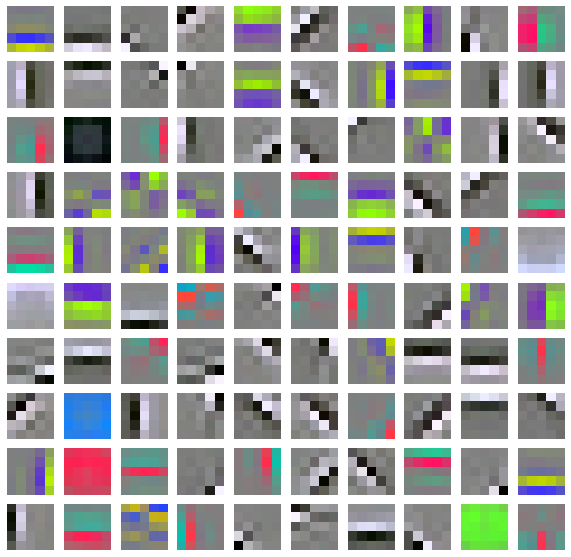

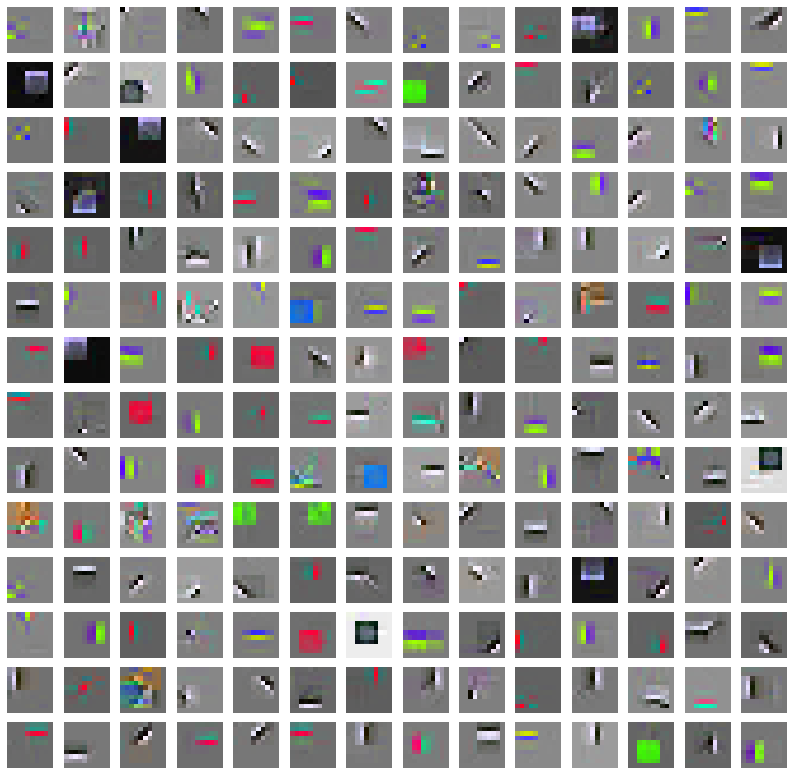

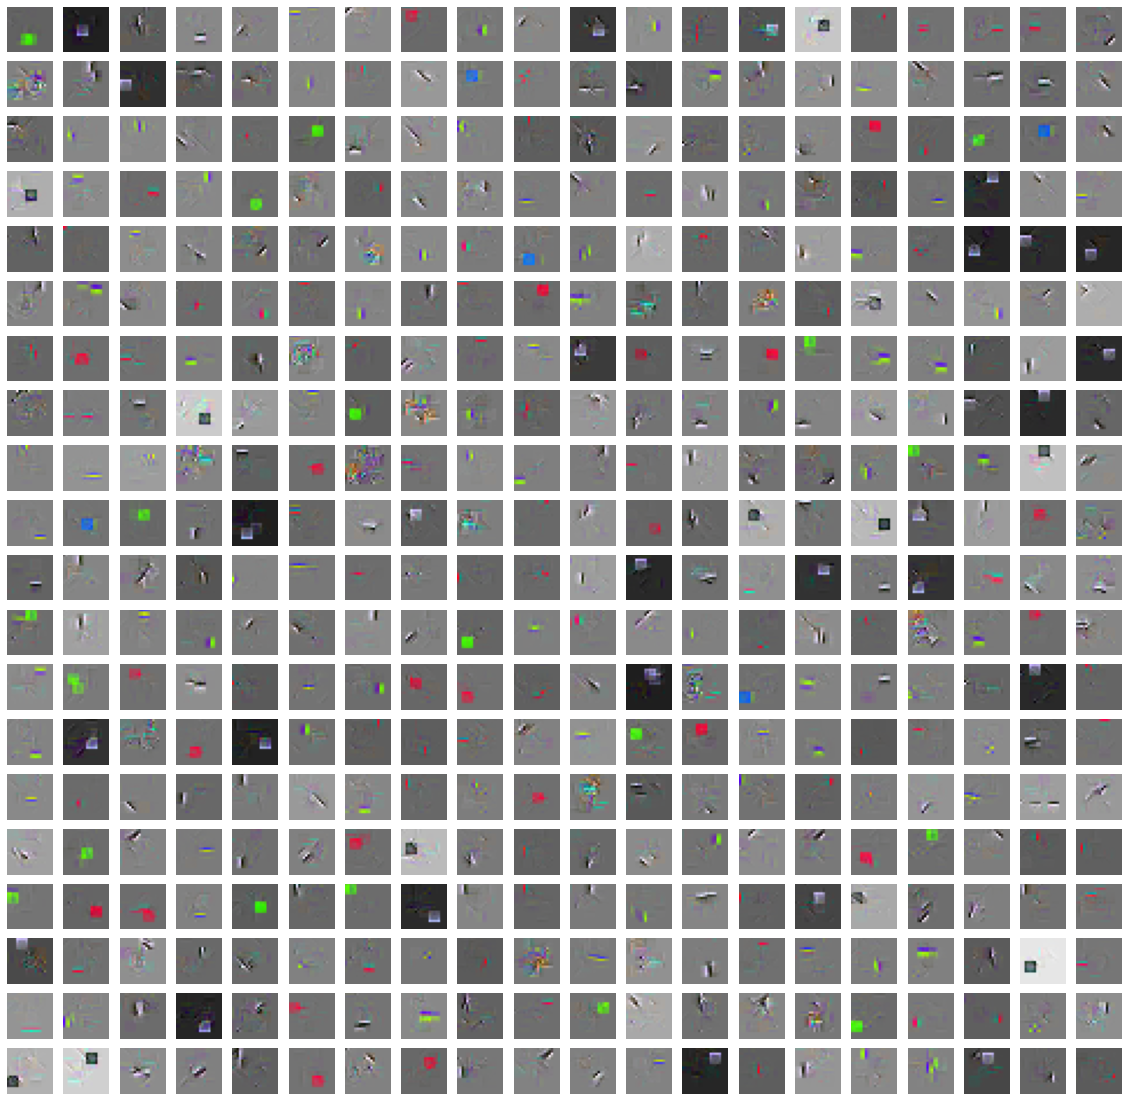

In [12]:

# Displaying receptive fields

#rfs=[]
rfsL1unnorm = []
rfsizes= [SIZES[0]]
figs=[]
stepsizes=[1]
fig = plt.figure(figsize=(np.sqrt(N[0]), np.sqrt(N[0])))
wnp = w[0].data.cpu().numpy()
#wnp = wnp - np.min(wnp); wnp = wnp / np.max(wnp)
for numpic in range(N[0]):
    ax = plt.subplot(np.ceil(np.sqrt(N[0])), np.ceil(np.sqrt(N[0])), numpic+1)


    if USEFLAT:
        # If using the flattening convolution
        wn = wnp[numpic,:,0,0]   # wn is a 1D vector of size sizes[0]*sizes[0]*NbInputChannels
        wn = wn.reshape((NBINPUTCHANNELS, SIZES[0], SIZES[0]))
    else:
        # Otherwise:
        wn = wnp[numpic,:,:,:]



    if not RGB:
        assert(wn.shape[0] == 1)
        wn = np.repeat(wn, 3, axis=0)
    wn = np.moveaxis(wn, 0, 2)
    rfsL1unnorm.append(wn)
    wn = .5 + .5 * wn / (1e-10 + np.max(np.abs(wn)))  # all values lie within [0, 1], with 0 being .5
    #wn = wn-np.min(wn); wn = wn / (1e-9 + np.max(wn))
    #wn[:,:,0]=0
    ax.imshow(wn)
    ax.set_axis_off()

figs.append(fig)
rfsunnorm = [np.stack(rfsL1unnorm, axis=0)]
# rfL2size = STRIDES[0] * POOLSTRIDES[0]*DILATIONS[1]*(SIZES[1]-1)+SIZES[0]
# rfL3size = STRIDES[1] * POOLSTRIDES[1]*STRIDES[0] * POOLSTRIDES[0]*DILATIONS[1] * (SIZES[2]-1)+rfL2size
# I get rid of dilations because they're probably wrong
for numl in range(1,NL):
        wnp = w[numl].cpu().detach().numpy()
        stepsize = POOLSTRIDES[numl-1]*STRIDES[numl-1]*stepsizes[numl-1] # Step size (in pixels) b/w successive input RFs within my own RF; would also be the step size b/w successive me's, but neglecting my own MPstride and next levels's stride
        stepsizes.append(stepsize)
        rfsize = stepsize * (SIZES[numl] - 1) + rfsizes[numl-1] + (POOLDIAMS[numl-1]-1) * stepsizes[numl-1]
        rfsizes.append(rfsize)
        print("RF size for layer", str(numl+1), ":", rfsize, " - Step size:", stepsize)
        #rfsthislayer = []
        rfsthislayerunnorm = []
        fig = plt.figure(figsize=(np.sqrt(N[numl]), np.sqrt(N[numl])))
        for nn in range(N[numl]):
            ax = plt.subplot(np.ceil(np.sqrt(N[numl])),np.ceil(np.sqrt(N[numl])),nn+1)
            if USEFLAT: 
                wn = wnp[nn,:,0,0]   # wn is a 1D vector of size sizes[0]*sizes[0]*NbInputChannels
                wn = wn.reshape((N[numl-1], SIZES[numl], SIZES[numl]))
            else:
                wn = wnp[nn,:,:,:]
            #print(np.sort(wn[:,3,0]))
            pic = np.zeros((rfsize, rfsize, 3))
            for xin in range(SIZES[numl]):
                for yin in range(SIZES[numl]):
                    avgrf = wn[:, xin, yin][:, np.newaxis, np.newaxis, np.newaxis] * rfsunnorm[numl-1]
                    avgrf = np.sum(avgrf, axis=0)
                    pic[xin*stepsize:xin*stepsize+rfsizes[numl-1], yin*stepsize:yin*stepsize+rfsizes[numl-1],:] += avgrf
                    
                    # For L3: 
                    # avgrf = wn[:, xin, yin][:, np.newaxis, np.newaxis, np.newaxis] * rfsL2unnorm
                    # avgrf = np.sum(avgrf, axis=0)
                    # rx = xin*STRIDES[1]*POOLSTRIDES[1]*STRIDES[0]*POOLSTRIDES[0]*DILATIONS[1]; ry = yin*STRIDES[1]*POOLSTRIDES[1]*STRIDES[0]*POOLSTRIDES[0]*DILATIONS[1]
                    # pic[rx:rx+rfL2size, ry:ry+rfL2size,:] += avgrf

            rfsthislayerunnorm.append(pic)
            pic = pic-np.min(pic); pic = pic / (1e-9 + np.max(pic))
            ax.imshow(pic)
            ax.set_axis_off()
            #rfsthislayer.append(pic)
        rfsunnorm.append(np.stack(rfsthislayerunnorm, axis=0))
        figs.append(fig)

for numl in range(NL):        
    figs[numl].savefig("FigRFs"+str(numl+1)+"_pm"+str(PROBAMASKS[1])+"_Tri"+USETRIANGLE+"_l1p"+str(L1PEN[1])+"k"+str(K[0])+str(K[1])+str(K[2])+".png")

        #rfs.append(rfsthislayer)

tensor(868.3934, device='cuda:0', grad_fn=<SumBackward0>)
tensor(400., device='cuda:0', grad_fn=<SumBackward0>)
tensor(256.1085, device='cuda:0', grad_fn=<SumBackward0>)
tensor(204.2781, device='cuda:0', grad_fn=<SumBackward0>)
tensor(172.6287, device='cuda:0', grad_fn=<SumBackward0>)
tensor(0.0592, device='cuda:0', grad_fn=<MedianBackward0>)


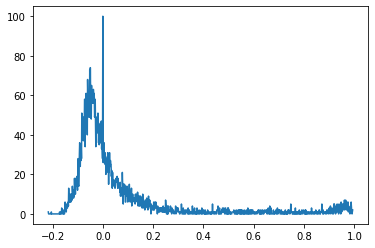

In [13]:
# Distribution of weights in last layer

print(torch.sum(torch.abs(w[2])))
print(torch.sum(w[2]**2))
print(torch.sum(w[2]**4))
print(torch.sum(w[2]**6))
print(torch.sum(w[2]**8))
wa = torch.abs(w[2])
print(torch.median(wa[wa>1e-10]))

plt.figure()
hh=np.histogram(w[2].data.cpu().numpy().flat, 1000)
z=hh[0]; b = hh[1][:-1]
np.savez(  'hist.npz', b, z)
z[z>100]=100
plt.plot(b,z)


10000 10000
(10000, 400)
True firing rates of 100 first cells over the second half of the whole experiment:
[0.0032 0.0014 0.0002 0.0022 0.002  0.002  0.0028 0.002  0.0018 0.0028
 0.0022 0.0034 0.0028 0.002  0.0022 0.0022 0.003  0.0022 0.0036 0.0022
 0.0026 0.0024 0.003  0.002  0.0034 0.0016 0.003  0.0016 0.0028 0.0028
 0.0044 0.0034 0.0016 0.0032 0.0024 0.0028 0.0036 0.001  0.0032 0.0024
 0.001  0.003  0.0028 0.0018 0.0012 0.0026 0.0032 0.0022 0.0022 0.0014
 0.0016 0.003  0.0034 0.0024 0.003  0.0028 0.002  0.003  0.0036 0.0024
 0.0036 0.0036 0.0034 0.0026 0.0018 0.002  0.0034 0.0018 0.0034 0.0022
 0.0028 0.0016 0.0028 0.0006 0.0022 0.0028 0.0024 0.0026 0.0026 0.0042
 0.0024 0.0034 0.0012 0.002  0.003  0.0016 0.002  0.004  0.0022 0.0024
 0.0018 0.0014 0.0026 0.0026 0.002  0.0016 0.0036 0.0012 0.0016 0.0034]
Their std dev:
0.000792404
Correlation between firing (outy) over 2nd half of experiment (in position 0,0)
(400, 400)
[[ 1.       -0.050656 -0.052228 -0.045677 -0.054519]
 [-0.05065

/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


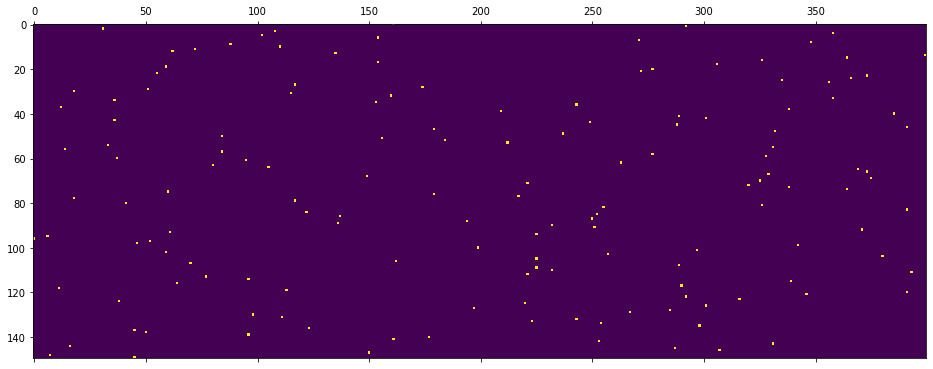

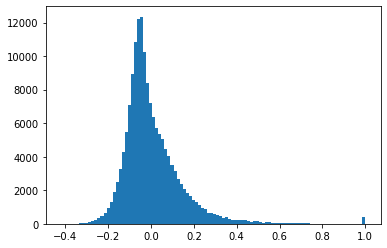

In [14]:
# Show firing (WTA wins), and correlation in output between channels in last layer

# note that firing is WTA wins (determines plasticity) while output is "outy" (computed by triangle method, denser, used as actual layer output)


print(len(allfirings[2]), len(allfirings_p[2]))
af = allfirings_p[2] #[:15000] # Excluding train/test
af = np.vstack(af)
print(af.shape)
plt.figure(figsize=(16,16))
plt.matshow(af[-150:,:], fignum=0)
np.set_printoptions(precision=6,suppress=True)
print("True firing rates of 100 first cells over the second half of the whole experiment:")
meanz = np.mean(af[af.shape[0]//2:,:], axis=0)[:100]
print(meanz)
print("Their std dev:")
print(np.std(meanz))

print("Correlation between firing (outy) over 2nd half of experiment (in position 0,0)")
afhalf = np.vstack(allfirings[2])
afhalf = afhalf[afhalf.shape[0]//2:, :]
cc = np.corrcoef(afhalf.T)
print(cc.shape)
print(cc[:5,:5])
plt.figure()
z = plt.hist(cc.flatten(),bins=100)
print("Similarity between this correlation matrix and the wlat computed in the experiment:")
print(wlat[2].shape)
wl = wlat[2].cpu().numpy()
print(wl[:5,:5])
print(np.corrcoef(wl.flatten(), cc.flatten()))
